<a href="https://colab.research.google.com/github/Livy-Li/Global_MLDS_Career_Development_Analysis/blob/main/Salary_Bucket_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

“The purpose of this assignment is to train, validate, and tune multi-class ordinary classification models that can classify, given a set of survey responses by a data scientist, what a survey respondent’s current yearly compensation bucket is.”

# Handle Missing Values

### Explaination

The dataset is imported and presented as a dataframe. After visually inspecting it, it is evident that there are a lot of missing values. For questions where only a single answer can be chosen, each question only exists in one column. If there is a missing value in the column, it is because the respondent did not answer the question. For questions where multiple answers can be chosen, every answer of the question occupies its own column and if the respondent did not select that answer, it is shown as a missing value. Therefore for these questions, a null value in a column means that answer is not selected, it does not necessarily mean the question was not answered by the respondent.

The true missing values are from respondents who did not select any answer of a question, meaning they simply skipped the entire question. The rest of the missing values are just pseudo-missing values and we can fill them with ‘0’ later in the encoding stage of data preprocessing.

Some helper functions are created to check the number of true missing values of each question and output them into a dataframe. The dataframe shows that some questions have the same amount of true missing values. For example, there are 561 respondents who did not answer Q7-Q15. Did these respondents collectively decide that they want to skip these questions? The answer is no, a further inspection into the survey methodology document reveals the answer. It turned out that participants who answered 'I have never written code' in Q6 were not given Q7-Q19 at all, because these questions are about coding, and these 561 participants could only have answered ‘None’ to these questions. For this reason, we can fill the missing values for these 561 participants for Q7 to Q19 to be ‘None’. The survey methodology document details which questions were not presented to a participant based on his/her answers to other questions, and we can fill these missing answers based on the dependency logic. 

After filling in these missing answers, there are still some more true missing values existing in some of the questions. These missing values are from respondents who skipped questions at their own will, and we do not know what their potential answers are. The approach to handle these missing values is by creating a new response category called ‘Unknown’ for each question. This approach is straightforward and accurate, there is no guesswork involved, and it would not disrupt the distribution of existing answers. It is suitable to use this approach because there are not many respondents who simply skipped questions for no reason, usually only a few hundred for each question. Given that the entire dataset has over 10k samples, these ‘Unknown’ categories would not have a huge impact. The disadvantage of this approach is that it adds new columns to the dataset without adding new information since the ‘Unknown’ columns are correlated with other columns. This disadvantage is not overly concerning because if the ‘Unknown’ categories do not have a huge impact, they would be filtered out in the feature selection step.

After performing the above tasks, the number of true missing values for each question is now zero, and we can move on to the encoding step.


### User Defined Helper Functions

In [ ]:
# put part A and part B of the same question next to each other
def rearrange_columns(df):
    column_names = list(df.columns)
    new_column_names = []
    for name in column_names:
        splited = name.split('_')
        if len(splited) == 1 or splited[1] != 'B':
            new_column_names.append(name)
        elif splited[1] == 'B' and len(splited) == 4:
            index = new_column_names.index(splited[0]+'_A_'+splited[2]+'_'+splited[3])
            new_column_names.insert(index+1, name)
        elif splited[1] == 'B' and len(splited) == 3:
            index = new_column_names.index(splited[0]+'_A_'+splited[2])
            new_column_names.insert(index+1, name)

    return new_column_names

In [ ]:
#extract only the question number of each question, with no part number
def get_q_number(df):
    column_names = list(df.columns)
    new_column_names = []
    for name in column_names:
        splited = name.split('_')
        new_column_names.append(splited[0])
    return new_column_names

In [ ]:
#count number of true null values 
#(i.e. did not choose any provided choices) for each question
def count_null_by_question(df):
    df1 = df[rearrange_columns(df)]
    q_number = get_q_number(df1)
    trav = 0
    question = []
    null_count = []
    for i in range(len(q_number)):
      if i == trav:
        if (i + 1 == len(q_number)) or (q_number[i] != q_number[i+1]):
          question.append(q_number[i])
          null_count.append(df1.iloc[:,i].isnull().sum())
          trav += 1
        
      else:
        if (i + 1 == len(q_number)) or (q_number[i] != q_number[i+1]) :
          question.append(q_number[i])
          null_count.append(df1.iloc[:,trav:i+1].isnull().all(1).sum())
          trav = i+1

    return question, null_count

In [ ]:
#get all columns name that include the question_number
def get_question_column_names(question_number, df):
  split_column_names = map(lambda column_name: column_name.split('_'), 
                           df.columns.to_list())
  split_question_column_names = filter(lambda split_name: 
                                       split_name[0] == question_number, 
                                       split_column_names)
  question_column_names = list(map(lambda split_names: '_'.join(split_names), 
                                   split_question_column_names))

  return question_column_names

### Handling Missing Values

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#read data, and drop the first row (containing the actual question)
#drop 'Time from Start to Finish (seconds)' column because it is not relavent
df = pd.read_csv('clean_kaggle_data_2020.csv')
df = df.drop([0]).reset_index(drop=True)
df = df.drop(['Time from Start to Finish (seconds)'], axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#take a look at the dataframe
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,Visual Studio,NaN,PyCharm,NaN,NaN,Sublime Text,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
1,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,NaN,NaN,Java,Javascript,NaN,NaN,Bash,NaN,NaN,NaN,R,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,Notepad++,Sublime Text,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
2,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,999"
3,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,NaN,PyCharm,NaN,NaN,Sublime Text,Vim / Emacs,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"
4,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"30,000-39,999"


In [ ]:
df.shape

(10729, 356)

In [ ]:
# display the number of null values for each columns
# If the question has multiple parts, the null value means the part is not selected
# It does not necessarily mean the question was not answered
# therefore for multiple choice question, these numbers are not very helpful
df.isnull().sum(axis=0)

Q1                   0
Q2                   0
Q3                   0
Q4                   0
Q5                   0
                 ...  
Q35_B_Part_9     10481
Q35_B_Part_10     9048
Q35_B_OTHER      10596
Q24_Encoded          0
Q24_buckets          0
Length: 356, dtype: int64

In [ ]:
#we want to display the null values by question
#these null counts shows the number of people who skipped all the parts of the questions
#these are the true null counts for each question
#the function used here can be found in the first section "User Defined Functions"
question, null_count = count_null_by_question(df)
df_q_null = pd.DataFrame(list(zip(question,null_count)), 
                         columns=['Question','Null Count']) 
df_q_null

,Question,Null Count
0,Q1,0
1,Q2,0
2,Q3,0
3,Q4,0
4,Q5,0
5,Q6,0
6,Q7,561
7,Q8,561
8,Q9,561
9,Q10,561


In [ ]:
#people who answered 'I have never written code' in Q6 were not asked Q7-Q19 (they are about coding)
#we can fill the NaN value with approprite choice for those questions such as 'None' and 'Never', based on the choices provided by the questions 
df.loc[df['Q6'] == 'I have never written code', ['Q7_Part_12','Q8','Q9_Part_11','Q10_Part_13','Q11','Q12_Part_3','Q14_Part_11','Q16_Part_15','Q17_Part_11','Q18_Part_6','Q19_Part_5']] = 'None'
df.loc[df['Q6'] == 'I have never written code', ['Q13']] = 'Never'
df.loc[df['Q6'] == 'I have never written code', ['Q15']] = 'I do not use machine learning methods'

In [ ]:
#people who answered 'I do not use machine learning methods' in Q15 were not asked Q16-Q19 (they are about machine learning)
#we can fill the NaN value with 'None' for those questions
df.loc[df['Q15'] == 'I do not use machine learning methods', ['Q16_Part_15','Q17_Part_11','Q18_Part_6','Q19_Part_5']] = 'None'

In [ ]:
#People who answered 'Convolutional Neural Networks'and 'Generative Adversarial Networks' in Q17 were given Q18 to answer
#Therefore for people who did not choose those two choices, we can fill their answer in Q18 as 'None' (because they were not presented with Q18)

df.loc[(df['Q17_Part_7'].isnull())&(df['Q17_Part_8'].isnull()),['Q18_Part_6']] = 'None'

#People who answered 'Recurrent Neural Networks'and 'Transformer Networks (BERT, gpt-3, etc)' in Q17 were given Q19 to answer
#Therefore for people who did not choose those two choices, we can fill their answer in Q19 as 'None' (because they were not presented with Q19)

df.loc[(df['Q17_Part_9'].isnull())&(df['Q17_Part_10'].isnull()),['Q19_Part_5']] = 'None'

In [ ]:
#questions that are independent of other questions
#a nan value means the respondent was presented with the question but did not answer it
#therefore the answer to the question is filled as 'Unknown' if it is a single choice question
#for multiple choice questions, a new column is created and 'Unknown' is filled as an answer
#the missing values are relatively small for these questions, the largest one is Q36

df.loc[df['Q25'].isnull(), 'Q25'] = 'Unknown'

df.insert(df.columns.to_list().index('Q26_A_OTHER')+1,'Q26_MISSING',np.nan)
df.loc[df[get_question_column_names('Q26', df)].isnull().all(1), ['Q26_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q29_A_OTHER')+1,'Q29_MISSING',np.nan)
df.loc[df[get_question_column_names('Q29', df)].isnull().all(1), ['Q29_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q31_A_OTHER')+1,'Q31_MISSING',np.nan)
df.loc[df[get_question_column_names('Q31', df)].isnull().all(1), ['Q31_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q33_A_OTHER')+1,'Q33_MISSING',np.nan)
df.loc[df[get_question_column_names('Q33', df)].isnull().all(1), ['Q33_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q35_A_OTHER')+1,'Q35_MISSING',np.nan)
df.loc[df[get_question_column_names('Q35', df)].isnull().all(1), ['Q35_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q36_OTHER')+1,'Q36_MISSING',np.nan)
df.loc[df[get_question_column_names('Q36', df)].isnull().all(1), ['Q36_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q37_OTHER')+1,'Q37_MISSING',np.nan)
df.loc[df[get_question_column_names('Q37', df)].isnull().all(1), ['Q37_MISSING']] = 'Unknown'

df.loc[df['Q38'].isnull(), 'Q38'] = 'Unknown'

df.insert(df.columns.to_list().index('Q39_OTHER')+1,'Q39_MISSING',np.nan)
df.loc[df[get_question_column_names('Q39', df)].isnull().all(1), ['Q39_MISSING']] = 'Unknown'

In [ ]:
#People who answered 'Amazon Web Services (AWS)', 'Microsoft Azure' and 'Google Cloud Platform (GCP)'in Q26(AorB) were given Q27(AorB) and Q28(AorB) to answer
#Therefore for people who answered Q26 but did not choose those three choices, we can fill their answer in Q27 and Q28 as 'None'

df.loc[(
    df['Q26_MISSING'].isnull()&df['Q26_B_Part_1'].isnull()&df['Q26_B_Part_2'].isnull()&
    df['Q26_B_Part_3'].isnull()&df['Q26_B_Part_4'].isnull()&df['Q26_B_Part_5'].isnull()&
    df['Q26_B_Part_6'].isnull()&df['Q26_B_Part_7'].isnull()&df['Q26_B_Part_8'].isnull()&
    df['Q26_B_Part_9'].isnull()&df['Q26_B_Part_10'].isnull()&df['Q26_B_Part_11'].isnull()&
    df['Q26_B_OTHER'].isnull()&df['Q26_A_Part_1'].isnull()&df['Q26_A_Part_2'].isnull()&df['Q26_A_Part_3'].isnull()
    ),['Q27_A_Part_11','Q28_A_Part_10']] = 'None'

df.loc[(
    df['Q26_MISSING'].isnull()&df['Q26_A_Part_1'].isnull()&df['Q26_A_Part_2'].isnull()&
    df['Q26_A_Part_3'].isnull()&df['Q26_A_Part_4'].isnull()&df['Q26_A_Part_5'].isnull()&
    df['Q26_A_Part_6'].isnull()&df['Q26_A_Part_7'].isnull()&df['Q26_A_Part_8'].isnull()&
    df['Q26_A_Part_9'].isnull()&df['Q26_A_Part_10'].isnull()&df['Q26_A_Part_11'].isnull()&
    df['Q26_A_OTHER'].isnull()&df['Q26_B_Part_1'].isnull()&df['Q26_B_Part_2'].isnull()&df['Q26_B_Part_3'].isnull()
    ),['Q27_B_Part_11','Q28_B_Part_10']] = 'None'

In [ ]:
#Q30 was only asked to respondents that selected more than one choice for Q29A
#Therefore for people who answered Q29A but only choose one, we can fill their answer in Q30 as the same as Q29A
#for people who answered Q29B, we can fill their answer in Q30 as 'None'
test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_1')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'MySQL'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_2')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'PostgreSQL'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_3')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'SQLite'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_4')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Oracle Database'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_5')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'MongoDB'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_6')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Snowflake'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_7')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'IBM Db2'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_8')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Microsoft SQL Server'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_9')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Microsoft Access'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_10')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Microsoft Azure Data Lake Storage'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_11')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Amazon Redshift'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_12')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Amazon Athena'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_13')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Amazon DynamoDB'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_14')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Google Cloud BigQuery'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_15')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Google Cloud SQL'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_16')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Google Cloud Firestore'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_Part_17')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'None'

test_list = get_question_column_names('Q29', df)
test_list.remove('Q29_A_OTHER')
df.loc[df[test_list].isnull().all(1),['Q30']] = 'Other'


df.loc[(
    df['Q29_MISSING'].isnull()&df['Q29_A_Part_1'].isnull()&df['Q29_A_Part_2'].isnull()&
    df['Q29_A_Part_3'].isnull()&df['Q29_A_Part_4'].isnull()&df['Q29_A_Part_5'].isnull()&
    df['Q29_A_Part_6'].isnull()&df['Q29_A_Part_7'].isnull()&df['Q29_A_Part_8'].isnull()&
    df['Q29_A_Part_9'].isnull()&df['Q29_A_Part_10'].isnull()&df['Q29_A_Part_11'].isnull()&
    df['Q29_A_Part_12'].isnull()&df['Q29_A_Part_13'].isnull()&df['Q29_A_Part_14'].isnull()&
    df['Q29_A_Part_15'].isnull()&df['Q29_A_Part_16'].isnull()&df['Q29_A_Part_17'].isnull()&
    df['Q29_A_OTHER'].isnull()
    ),['Q30']] = 'None'

In [ ]:
#Q32 was only asked to respondents that selected more than one choice for Q31A.
#Therefore for people who answered Q31A but only choose one, we can fill their answer in Q32 as the same as Q31A
#for people who answered Q31B, we can fill their answer in Q32 as 'None'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_1')
df.loc[df[test_list].isnull().all(1),['Q32']] = '​Amazon QuickSight'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_2')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Microsoft Power BI'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_3')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Google Data Studio'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_4')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Looker'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_5')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Tableau'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_6')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Salesforce'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_7')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Einstein Analytics'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_8')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Qlik'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_9')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Domo'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_10')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'TIBCO Spotfire'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_11')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Alteryx'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_12')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Sisense'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_13')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'SAP Analytics Cloud'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_Part_14')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'None'

test_list = get_question_column_names('Q31', df)
test_list.remove('Q31_A_OTHER')
df.loc[df[test_list].isnull().all(1),['Q32']] = 'Other'


df.loc[(
    df['Q31_MISSING'].isnull()&df['Q31_A_Part_1'].isnull()&df['Q31_A_Part_2'].isnull()&
    df['Q31_A_Part_3'].isnull()&df['Q31_A_Part_4'].isnull()&df['Q31_A_Part_5'].isnull()&
    df['Q31_A_Part_6'].isnull()&df['Q31_A_Part_7'].isnull()&df['Q31_A_Part_8'].isnull()&
    df['Q31_A_Part_9'].isnull()&df['Q31_A_Part_10'].isnull()&df['Q31_A_Part_11'].isnull()&
    df['Q31_A_Part_12'].isnull()&df['Q31_A_Part_13'].isnull()&df['Q31_A_Part_14'].isnull()&
    df['Q31_A_OTHER'].isnull()
    ),['Q32']] = 'None'

In [ ]:
#Q34 was only asked to respondents that answered affirmatively to Q33
#Therefore for people who answered Q33 with 'None', we can fill their answer in Q34 'None'

test_list = get_question_column_names('Q33', df)
test_list.remove('Q33_A_Part_7')
df.loc[df[test_list].isnull().all(1),['Q34_A_Part_11']] = 'None'

test_list = get_question_column_names('Q33', df)
test_list.remove('Q33_B_Part_7')
df.loc[df[test_list].isnull().all(1),['Q34_B_Part_11']] = 'None'

In [ ]:
#The rest of the NAN are the people who were presented with the questions but skipped them
#Therefore the answer to the question is filled as 'Unknown'
df.insert(df.columns.to_list().index('Q18_OTHER')+1,'Q18_MISSING',np.nan)
df.loc[df[get_question_column_names('Q18', df)].isnull().all(1), ['Q18_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q19_OTHER')+1,'Q19_MISSING',np.nan)
df.loc[df[get_question_column_names('Q19', df)].isnull().all(1), ['Q19_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q27_A_OTHER')+1,'Q27_MISSING',np.nan)
df.loc[df[get_question_column_names('Q27', df)].isnull().all(1), ['Q27_MISSING']] = 'Unknown'

df.insert(df.columns.to_list().index('Q28_A_OTHER')+1,'Q28_MISSING',np.nan)
df.loc[df[get_question_column_names('Q28', df)].isnull().all(1), ['Q28_MISSING']] = 'Unknown'

df.loc[df['Q30'].isnull(), 'Q30'] = 'Unknown'

df.loc[df['Q32'].isnull(), 'Q32'] = 'Unknown'

df.insert(df.columns.to_list().index('Q34_A_OTHER')+1,'Q34_MISSING',np.nan)
df.loc[df[get_question_column_names('Q34', df)].isnull().all(1), ['Q34_MISSING']] = 'Unknown'

In [ ]:
#Check again, all the NaN value by question are now zero!
question, null_count = count_null_by_question(df)
df_q_null = pd.DataFrame(list(zip(question,null_count)), columns=['Question','Null Count']) 
df_q_null

,Question,Null Count
0,Q1,0
1,Q2,0
2,Q3,0
3,Q4,0
4,Q5,0
5,Q6,0
6,Q7,0
7,Q8,0
8,Q9,0
9,Q10,0


# Encoding

The features and targets of the dataset are separated in this step and the encoding is performed on the features. The encoding methods used are Ordinal Encoding and One Hot Encoding. Ordinal Encoding is used for questions where only one answer can be chosen that have ordered responses. For example, Q1 asks for the age of the participants. The answers are grouped into different age groups and these age groups can be ordered from the youngest (18-21) to the oldest (70+). By using Ordinal Encoding, smaller numbers are assigned for younger age groups, and larger numbers are assigned for older age groups. The advantage of this Ordinal Encoding is that it preserves the ordered relationship between groups and this information can be valuable for making predictions. In the context of this project, the increase in age of the participants can be positively correlated with increasing salaries, as people tend to earn more with experience and seniority. The disadvantage of Ordinal Encoding is that between different questions the encoding scales are not comparable. For example, a value of 3 representing the age group ‘25-29’ in Q1 is not comparable to a value of 3 representing ‘Bachelor’s degree’ in Q4. In addition, this causes a difference in maximum and minimum values between questions, because some of the questions have more groups than others. We can attempt to reduce some of the disadvantages related to Ordinal Encoding later by scaling and regularizing features.

One Hot Encoding is used for questions where only one answer can be chosen that do not have ordered responses, such as gender (Q2) and country of residence (Q3). By using One Hot Encoding, each unique response of a question becomes a new column, and the columns are filled with binary integers (0 or 1) to indicate if the response is selected. The advantage of One Hot Encoding is that it can represent non-ordinal data using binary integers without losing information. The disadvantage is low information density. The result of One Hot Encoding questions where one answer can be chosen is stored in multiple different columns instead of a sparse matrix to keep a consistent form with the questions where multiple answers can be chosen. Therefore extra columns are created filled with mostly zeros, especially for questions with a considerable amount of categories such as country of residence (Q3).

Finally, we can fill all the missing values with zeros for questions where multiple answers can be chosen and then replace the strings with 1. The results are similar to One Hot Encoding: the binary integers are used to indicate whether a given option is selected or not.  The resulting features have 509 columns. At this point, the dataframe has no missing values anymore.


In [ ]:
!pip install category_encoders
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Use abbreviations for countries with longer names
df['Q3'] = df['Q3'].replace({"United States of America":"US",
                                   "United Arab Emirates":"UAE",
                                   "United Kingdom of Great Britain and Northern Ireland":"UK",
                                   "Iran, Islamic Republic of...":"Iran"})

In [ ]:
#separate features and target
df_features = df.drop(['Q24','Q24_Encoded','Q24_buckets'],axis=1)
df_targets = df[['Q24_buckets','Q24_Encoded']]

In [ ]:
#Encode ordinal data with OrdinalEncoder, including age (Q1), education (Q4)
#programming years(Q6),TPU using times (Q13), machine learning using times (Q15)
#size of the company (Q20), work force size (Q21), current usage of maching learning (Q22)
#spending on ml tools (Q25)
#all questions mentioned above are single choice questions

encoderQ1= ce.OrdinalEncoder(cols=['Q1'],return_df=True,
                           mapping=[{'col':'Q1',
'mapping':{'18-21':1,'22-24':2,'25-29':3,'30-34':4,'35-39':5,'40-44':6,
           '45-49':7,'50-54':8,'55-59':9,'60-69':10,'70+':11}}])
df_features = encoderQ1.fit_transform(df_features)

encoderQ4= ce.OrdinalEncoder(cols=['Q4'],return_df=True,
                           mapping=[{'col':'Q4',
'mapping':{'I prefer not to answer':0,'No formal education past high school':1,
           'Some college/university study without earning a bachelor’s degree':2,
           'Bachelor’s degree':3,'Master’s degree':4,'Doctoral degree':5,
           'Professional degree':6}}])
df_features = encoderQ4.fit_transform(df_features)

encoderQ6= ce.OrdinalEncoder(cols=['Q6'],return_df=True,
                           mapping=[{'col':'Q6',
'mapping':{'I have never written code':1,'< 1 years':2,'1-2 years':3,'3-5 years':4,
           '5-10 years':5,'10-20 years':6,'20+ years':7}}])
df_features = encoderQ6.fit_transform(df_features)

encoderQ13= ce.OrdinalEncoder(cols=['Q13'],return_df=True,
                           mapping=[{'col':'Q13',
'mapping':{'Never':1,'Once':2,'2-5 times':3,'6-25 times':4,'More than 25 times':5}}])
df_features = encoderQ13.fit_transform(df_features)

encoderQ15= ce.OrdinalEncoder(cols=['Q15'],return_df=True,
                           mapping=[{'col':'Q15',
'mapping':{'I do not use machine learning methods':1,'Under 1 year':2,'1-2 years':3,
           '2-3 years':4,'3-4 years':5,'4-5 years':6,'5-10 years':7,
           '10-20 years':8,'20 or more years':9}}])
df_features = encoderQ15.fit_transform(df_features)

encoderQ20= ce.OrdinalEncoder(cols=['Q20'],return_df=True,
                           mapping=[{'col':'Q20',
'mapping':{'0-49 employees':1,'50-249 employees':2,'250-999 employees':3,
           '1000-9,999 employees':4,'10,000 or more employees':5}}])
df_features = encoderQ20.fit_transform(df_features)

encoderQ21= ce.OrdinalEncoder(cols=['Q21'],return_df=True,
                           mapping=[{'col':'Q21',
'mapping':{'0':1,'1-2':2,'3-4':3,'5-9':4,'10-14':5,'15-19':6,'20+':7}}])
df_features = encoderQ21.fit_transform(df_features)

encoderQ22= ce.OrdinalEncoder(cols=['Q22'],return_df=True,
                           mapping=[{'col':'Q22',
'mapping':{'I do not know':0,'No (we do not use ML methods)':1,
           'We are exploring ML methods (and may one day put a model into production)':2,
           'We use ML methods for generating insights (but do not put working models into production)':3,
           'We recently started using ML methods (i.e., models in production for less than 2 years)':4,
           'We have well established ML methods (i.e., models in production for more than 2 years)':5}}])
df_features = encoderQ22.fit_transform(df_features)

encoderQ25= ce.OrdinalEncoder(cols=['Q25'],return_df=True,
                           mapping=[{'col':'Q25',
'mapping':{'Unknown':0,'$0 ($USD)':1,'$1-$99':2,'$100-$999':3,'$1000-$9,999':4,
           '$10,000-$99,999':5,'$100,000 or more ($USD)':6}}])
df_features = encoderQ25.fit_transform(df_features)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
#The rest of the single choice questions (Q2,Q3,Q5,Q8,Q11,Q30,Q32,Q38) are encoded with OneHotEncoder
question_list = ['Q2','Q3','Q5','Q8','Q11','Q30','Q32','Q38']
hot_encoder=ce.OneHotEncoder(cols=question_list,handle_unknown='return_nan',return_df=True,use_cat_names=True)
df_features = hot_encoder.fit_transform(df_features)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
#all it left are the multiple choice questions
#we can replace the nan values with number 0
#we can replace the strings with number 1
#the results for these question are similar to OneHotEncoding for single choice questions
df_features = df_features.fillna(0)
column_list = df_features.columns.to_list()
for li in column_list:
    df_features[li] = pd.to_numeric(df_features[li], errors='coerce').fillna(1).astype(int)

In [ ]:
#check the info of the df_features now
#there are no null values
#all data type are int, meaning encoding is done successfully
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10729 entries, 0 to 10728
Columns: 509 entries, Q1 to Q35_B_OTHER
dtypes: int64(509)
memory usage: 41.7 MB


In [ ]:
#look at the df again just to check
df_features.shape

(10729, 509)

# Feature Importance

The tools used to visualize feature importance are the Random Forest Classifier and correlation heatmap. The dataset is separated into train and test sets and only the training set is used in the Random Forest Model. Random Forest Classifier employs numerous decision trees working as an ensemble to make class predictions. It is used because it supports multiclass datasets and is considered to be accurate and robust. It has a convenient impurity-based feature importances property built into the model that we can use to visualize feature importance. However, Random Forest works better with an uncorrelated dataset, therefore a correlation heatmap is also generated as a supplement. The plots are presented below.


In [ ]:
!pip install heatmapz

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from heatmap import heatmap, corrplot

In [ ]:
#split train and test sets before applying any ml methods
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_targets, test_size=0.3, random_state=42)

In [ ]:
#Using random forest classifier to explore feature importance
reg = RandomForestClassifier()
reg.fit(X_train, y_train['Q24_buckets'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#look at feature importance given by random forest regressor
df_feature_importance = pd.DataFrame(reg.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
Q1,0.028464
Q6,0.022606
Q20,0.020162
Q3_US,0.019527
Q25,0.018495
...,...
Q32_Sisense,0.000059
Q30_Google Cloud Firestore,0.000035
Q3_Nepal,0.000004
Q18_MISSING,0.000000


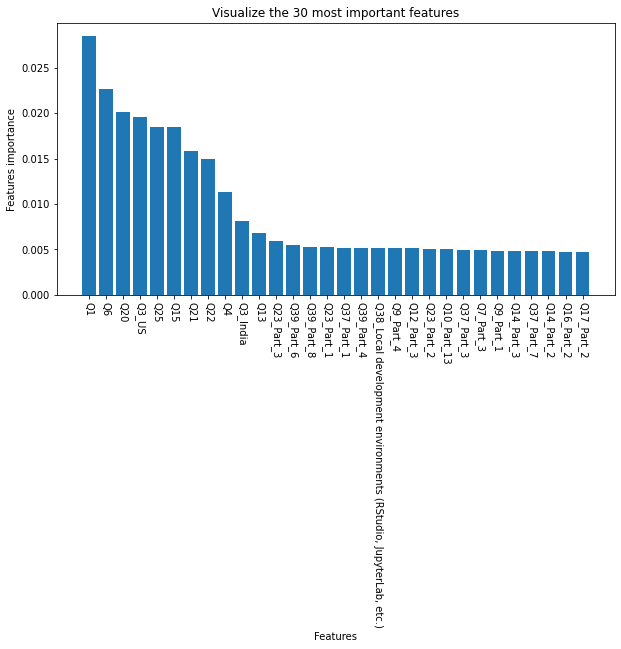

In [ ]:
#Visualize the 30 most important features given by the random forest regression
df_feature_importance30 = df_feature_importance.head(30)
plt.figure(figsize=(10, 5))
plt.bar(df_feature_importance30.index,df_feature_importance30['feature importance'])
plt.xticks(rotation=-90)
plt.title('Visualize the 30 most important features')
plt.xlabel('Features')
plt.ylabel('Features importance')
plt.show()

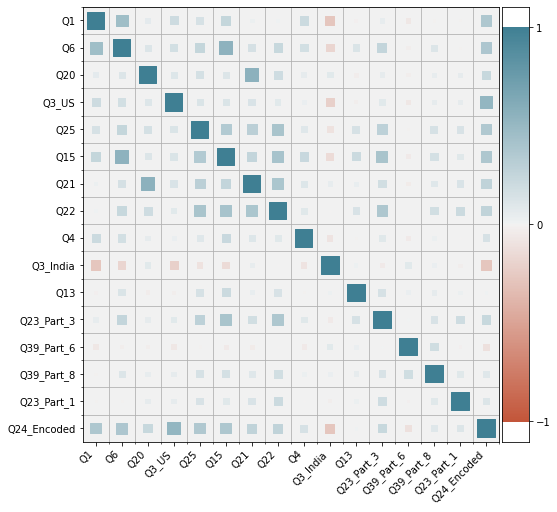

In [ ]:
#look at the correlation plot between the 15 most important features and the target
first15 = df_feature_importance.head(15).index.to_list()
df_feature_15 = pd.concat([X_train[first15],y_train], axis=1)

plt.figure(figsize=(8, 8))
corrplot(df_feature_15.corr(), size_scale=300);

In [ ]:
df_features.head()

,Q1,Q2_Man,Q2_Woman,Q2_Nonbinary,Q2_Prefer not to say,Q2_Prefer to self-describe,Q3_US,Q3_Argentina,Q3_Germany,Q3_Canada,Q3_Switzerland,Q3_India,Q3_Russia,Q3_South Africa,Q3_Netherlands,Q3_Pakistan,Q3_Other,Q3_Indonesia,Q3_Belarus,Q3_Ukraine,Q3_Saudi Arabia,Q3_Taiwan,Q3_China,Q3_Italy,Q3_UAE,Q3_Colombia,Q3_Viet Nam,Q3_UK,Q3_Egypt,Q3_Brazil,Q3_Mexico,Q3_Poland,Q3_Nigeria,Q3_France,Q3_Belgium,Q3_Turkey,Q3_Spain,Q3_Iran,Q3_Japan,Q3_Tunisia,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The first figure shows the 30 most important features given by the Random Forest Cassifier. The top 5 features that are most related to a survey respondent’s yearly compensation are age (Q1), programming experience (Q6), machine learning experience (Q15), size of company (Q20), and whether or not the respondent currently resides in the US (Q3 - US).  The correlation plot only uses the top 15 features plus the encoded target (Q24_Encoded), and there is a colour bar indicating the degree of correlation. The only negative correlation shown is if a respondent lives in India. The participant’s age, programming experience and machine learning experience are naturally more correlated to each other than other features.

#Feature Engineering and Feature Selection

Feature engineering is important because it better prepares the dataset to represent the underlying question. To a certain degree, feature engineering dictates how well the model prediction can be, and how insightfully the result can be interpreted. Because the dataset has over 500 columns for features, feature engineering can be applied to reduce the number of features.  In this case, reducing the number of features can greatly reduce the amount of time needed to process the dataset when fitting models. Since encoding country of residence data generated a lot of new columns and only two countries (US and India) rank among the top 30 in feature importance, we can group all the other countries into the ‘Q3_Other’ column, thereby eliminating more than 50 columns.

Feature selection can further reduce the number of features in our dataset. It is performed by using Ordinal Logistic Regression with L1 penalty. Ordinal Logistic Regression is implemented using the Logistic Regression Model from sklearn as a binary classifier. The target has 15 different salary buckets, therefore the binary classifier needs to run 14 times, each time changing the class label of samples to be either 0 or 1. For example, the first time the samples belong to the salary bucket ‘0-9999’ are set to class 0, and the samples belong to the rest of the salary buckets are set to class 1. The second time the samples belong to the salary bucket ‘0-9999’ and ‘10000-19999’ are set to class 0, and the samples belong to the rest of the salary buckets are set to class 1.

Because of the use of the L1 penalty term, not all features are selected when fitting the model. The SelectFromModel transformer can select all features with non-zero coefficients, and return a boolean value of whether a feature is selected using .get_support(). Only features that have non-zero coefficients for all 14 binary classifiers are selected. The number of columns selected is slightly different each time, at around 60 columns.

Compared to the 509 columns before feature engineering, the size of the features has been greatly reduced. This is beneficial because it reduces the complexity of the dataset and can improve efficiency in later stages. However, this might reduce the accuracy of our prediction results to some degree, so the criterion of feature selection can be loosened if the final prediction accuracy is too low after we implement the model.


In [ ]:
#feature engineering: grouping all countries except US and India in to Others
#reducing 52 columns

df_features.loc[(df_features['Q3_US'] == 0) & (df_features['Q3_India'] == 0),['Q3_Other']] = 1

df_features = df_features.drop(['Q3_Argentina','Q3_Germany','Q3_Canada','Q3_Switzerland',
                                'Q3_Russia','Q3_South Africa','Q3_Netherlands','Q3_Pakistan',
                                'Q3_Indonesia','Q3_Belarus','Q3_Ukraine','Q3_Saudi Arabia',
                                'Q3_Taiwan','Q3_China','Q3_Italy','Q3_UAE','Q3_Colombia',
                                'Q3_Viet Nam','Q3_UK','Q3_Egypt','Q3_Brazil','Q3_Mexico',
                                'Q3_Poland','Q3_Nigeria','Q3_France','Q3_Belgium','Q3_Turkey',
                                'Q3_Spain','Q3_Iran','Q3_Japan','Q3_Tunisia','Q3_Romania',
                                'Q3_Republic of Korea','Q3_Chile','Q3_Ireland','Q3_Sweden',
                                'Q3_Greece','Q3_Australia','Q3_Malaysia','Q3_Philippines',
                                'Q3_Nepal','Q3_Kenya','Q3_South Korea','Q3_Morocco','Q3_Portugal',
                                'Q3_Thailand','Q3_Peru','Q3_Bangladesh','Q3_Israel','Q3_Sri Lanka',
                                'Q3_Singapore','Q3_Ghana'],axis=1)

df_features.shape

(10729, 457)

In [ ]:
#feature selection
from sklearn.feature_selection import SelectFromModel


# WARNING: This block runs for some time (5mins in GoogleColab) because of feature volumes.


# Use L1 LogisticRegression to select features
# because there are 15 salary buckets, the for loop runs for 15-1 = 14 times, each time changing class labels to only 0 and 1 and shuffling data
# SelectFromModel selects features with non-zero coefficients
# .get_support gives a boolean value of whether a feature is selected, they are recorded for each loop in the selector_list

selector_list = []
for i in range(14):
    y_train_copy = y_train.copy()
    y_train_copy = y_train_copy['Q24_Encoded']

    y_train_copy[y_train_copy <= i] = 0
    y_train_copy[y_train_copy > i] = 1

    clf = LogisticRegression(penalty='l1', tol=0.001, C=1.0, random_state=0, solver='saga', max_iter=500).fit(X_train, y_train_copy)
    selector = SelectFromModel(clf, prefit=True)
    temp = selector.get_support()
    selector_list.append(temp)


# put the selector result in a df
df_selector = pd.DataFrame(list(zip(selector_list[0],selector_list[1],selector_list[2],
                                    selector_list[3],selector_list[4],selector_list[5],
                                    selector_list[6],selector_list[7],selector_list[8],
                                    selector_list[9],selector_list[10],selector_list[11],
                                    selector_list[12],selector_list[13])), 
                           columns=['run1','run2','run3','run4','run5','run6','run7','run8',
                                    'run9','run10','run11','run12','run13','run14',])


# only features that are selected for all 14 loops during logistic regression are kept
df_selector['selected'] = np.nan
df_selector.loc[df_selector.sum(axis=1)==14,['selected']] = True
df_selector=df_selector.fillna(False)

# discarding features not selected for X_train and X_test
X_train = X_train.iloc[:,df_selector['selected'].to_list()]
X_test = X_test.iloc[:,df_selector['selected'].to_list()]

In [ ]:
X_train.columns

Index(['Q1', 'Q2_Man', 'Q2_Woman', 'Q3_US', 'Q3_India', 'Q3_UK', 'Q3_Spain',
       'Q3_Australia', 'Q3_Israel', 'Q4', 'Q5_Other', 'Q5_Data Analyst', 'Q6',
       'Q7_Part_7', 'Q7_OTHER', 'Q9_Part_3', 'Q9_Part_5', 'Q9_Part_7',
       'Q10_Part_11', 'Q10_Part_12', 'Q10_Part_13',
       'Q11_A personal computer or laptop',
       'Q11_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)',
       'Q12_Part_1', 'Q12_Part_3', 'Q13', 'Q14_Part_2', 'Q14_Part_9', 'Q15',
       'Q16_Part_2', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_12', 'Q20', 'Q21',
       'Q22', 'Q23_Part_3', 'Q23_Part_6', 'Q23_OTHER', 'Q25', 'Q26_A_Part_11',
       'Q27_A_Part_10', 'Q29_A_Part_6', 'Q29_A_Part_7', 'Q29_A_Part_8',
       'Q29_A_Part_10', 'Q29_A_Part_16', 'Q30_PostgresSQL ',
       'Q30_Microsoft SQL Server', 'Q31_MISSING', 'Q33_A_Part_2',
       'Q33_A_Part_7', 'Q36_Part_9', 'Q37_Part_3', 'Q37_Part_7', 'Q37_Part_8',
       'Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Q38_L

In [ ]:
len(X_train.columns)

64

# Model Implementation and Hyperparameter Tuning

The model used for prediction is the same model used for feature selection, the ordinal logistic regression as described in the last section. However this time, instead of selecting features, the algorithm predicts the probability of each sample belonging to each salary bucket. The algorithm is then used in a 10-fold cross-validation function, and the model accuracies of each fold are calculated. The model accuracies across the different folds are relatively consistent, ranging from 0.415 to 0.450, the average accuracy is about 0.439, with a very low variance of 0.0002.

The hyperparameters in the models are the norm used for penalization (penalty), dual or primal formulation (dual), tolerance for stopping criteria (tol), inverse of regularization strength (C), whether or not to have a bias term added to the decision function (fit_intercept), weight associated with different classes (class_weight), maximum iteration (max_iter), whether or not to reuse solution of the previous call to fit as initialization (warm_start), and when using ‘elasticnet’ as the penalty term, what ratio of L1 norm should be used (l1_ratio). Solver and solver-related parameters are not considered hyperparameters because different solvers have their own advantages and limitations, and solver ‘saga’ is used because it works with all types of penalty terms. 

The two hyperparameters chosen to perform grid search are L1_ratio and C.  L1_ratio is only used with the penalty ‘elesticnet’, which is a mix of L1 and L2 penalties. L1_ratio specifies the ratio of L1 norm in the mixture and can be between 0 and 1. if L1_ratio=0, it is equivalent to using the L2 norm as the penalty. Inverse of Regularization strength C is a positive float which specifies the degree of penalty; the smaller C is, the stronger the strength of the regularization.

The performance measure selected to choose the best model is the accuracy score, which computes the fraction where the predicted label exactly matches the true label. It is used because the target has multiple classes, and we are interested in the overall prediction accuracy. It is the same as the f1 score using ‘micro’ average. 

The result of the grid search shows that the best model is to use L1_ratio = 0.1, and C = 0.01. This combination of hyperparameters gives an average cross validation accuracy of 0.443, it should be noted that the improvement is very small from before the implementation of grid search, (from 0.439 to 0.443), and the difference of accuracy between different combinations are also very small. Based on bias-variance trade-off, the small L1_ratio shows that the model performs better with mostly L2 norm penalty, which makes the model more complex than if L1_ratio was higher. The regularization strength is relatively strong, which suggests a tendency to make the model less complex. These two parameters work well because they balance out the complexity of the model and prediction accuracies. 

In order to determine whether scaling and regularizing features can improve the model, two types of transformations are applied to the training data.  The first one is MinMaxScaler, it scales each feature individually such that it is between 0 and 1, it could potentially be helpful because it scales all the ordinal features to be between 0 and 1 but does not change binary features. The second one is StandardScaler, which standardizes the entire dataset by subtracting the mean and divide by the standard deviation. The scaled and standardized features are used for prediction again, however, the resulting accuracy did not show improvement, and cross-validation accuracy still remains at around 0.44. It appears that standardizing and scaling features are not necessary in this case.


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
# Ordinal logistic regression implemented using binary logistic regression classifier
# The output of this function is a dataframe that presents the probability of each sample belonging to a particular salary bucket
# The two hyperparameters selected to be tuned are: L1_ratio and c

def ordinal_logistic_regression(X_train, y_train, X_test, L1_ratio, c):
    proba_list = [np.zeros(len(X_test))]
    for i in range(14):
        y_train_copy = y_train.copy()
        y_train_copy = y_train_copy['Q24_Encoded']

        y_train_copy[y_train_copy <= i] = 0
        y_train_copy[y_train_copy > i] = 1

        clf = LogisticRegression(penalty='elasticnet', tol=0.001, C=c, random_state=0, solver='saga', max_iter=600, l1_ratio=L1_ratio).fit(X_train, y_train_copy)
        proba = clf.predict_proba(X_test)
        proba_list.append(proba[:,0])
    proba_list.append(np.ones(len(X_test)))
    
    proba_bucket_list = []
    for i in range(15):
      prob_bucket = proba_list[i+1] - proba_list[i]
      proba_bucket_list.append(prob_bucket)
    
    df_proba_bucket = pd.DataFrame(list(zip(proba_bucket_list[0],proba_bucket_list[1],proba_bucket_list[2],
                                    proba_bucket_list[3],proba_bucket_list[4],proba_bucket_list[5],
                                    proba_bucket_list[6],proba_bucket_list[7],proba_bucket_list[8],
                                    proba_bucket_list[9],proba_bucket_list[10],proba_bucket_list[11],
                                    proba_bucket_list[12],proba_bucket_list[13],proba_bucket_list[14])), 
                           columns=['0-9,999','10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999',
                                    '60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999',
                                    '125,000-149,999','150,000-199,999','200,000-249,999','>250,000'])
    
    return df_proba_bucket

In [ ]:
#ordinal logistic regression with Cross Validation
#the output of this function is the accuracy score for each fold
#folds = 10

def ten_fold_ordlogit(X, y, L1_ratio, c ):
    
    kf = KFold(n_splits=10)
    
    accuracy_outcome = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train,X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train,y_test = y.iloc[train_index,:],y.iloc[test_index,:]

        y_proba = ordinal_logistic_regression(X_train, y_train, X_test, c, L1_ratio)
        y_pred = y_proba.idxmax(axis='columns')
        
        accuracy = accuracy_score(y_test['Q24_buckets'], y_pred)
        accuracy_outcome.append(accuracy)

    return(accuracy_outcome)

In [ ]:
#This code block runs for about 5mins, therefore it is commented out, the oupput is still visiable
#apply the ordinal logistic regression with cross validation on the training set
#the results are visible below, mean accuracy is around 0.44

accuracy_outcome = ten_fold_ordlogit(X_train, y_train, L1_ratio=1.0, c=1.0)

for i in range(len(accuracy_outcome)):
    print(f"Fold {i+1} accuracy: {accuracy_outcome[i]}")

mean_accuracy = np.mean(accuracy_outcome)
var_accuracy = np.var(accuracy_outcome)
print(f"\nMean of accuracy: {mean_accuracy}") 
print(f"Variance of accuracy: {var_accuracy}") 

Fold 1 accuracy: 0.45006657789613846
Fold 2 accuracy: 0.41544607190412786
Fold 3 accuracy: 0.44873501997336884
Fold 4 accuracy: 0.4207723035952064
Fold 5 accuracy: 0.4181091877496671
Fold 6 accuracy: 0.44607190412782954
Fold 7 accuracy: 0.43275632490013316
Fold 8 accuracy: 0.4540612516644474
Fold 9 accuracy: 0.4434087882822903
Fold 10 accuracy: 0.4607190412782956

Mean of accuracy: 0.4390146471371505
Variance of accuracy: 0.00023476908728885213


In [ ]:
def grid_search (l1_ratio_list, C_list):

    accuracy_list = []
    Hparam_list = []

    for l1 in l1_ratio_list:
        for C in C_list:
            Hparam_list.append([l1,C])
            accuracy_outcome = ten_fold_ordlogit(X_train, y_train, L1_ratio=l1, c=C)
            accuracy_list.append(np.mean(accuracy_outcome))
            print(f'L1 ratio: {l1}, C: {C}')
            print(f'accuracy: {np.mean(accuracy_outcome)}\n')

    
    return Hparam_list, accuracy_list

In [ ]:
# #grid search runs for a very long time, therefore it is commented out, the oupput is still visiable

# l1_ratio_list = [0.1, 0.4, 0.7, 1.0]
# C_list = [1.0, 0.1, 0.01, 0.001]

# #use the grid search function defined above
# Hparam_list, accuracy_list = grid_search(l1_ratio_list, C_list)


# #turn grid search result into a df and rank by descending accuracy
# #the best values for the chosed hyperparameters are l1_ratio=0,1, c=0.01
# df_gridsearch = pd.DataFrame(list(zip(Hparam_list, accuracy_list)), 
#                             columns=['[l1, C]', 'accuracy'])

# df_gridsearch.sort_values(by=['accuracy'], ascending=False)

L1 ratio: 0.1, C: 1.0
accuracy: 0.43981358189081227

L1 ratio: 0.1, C: 0.1
accuracy: 0.44234354194407455

L1 ratio: 0.1, C: 0.01
accuracy: 0.44354194407456726

L1 ratio: 0.1, C: 0.001
accuracy: 0.44340878828229024

L1 ratio: 0.4, C: 1.0
accuracy: 0.4394141145139813

L1 ratio: 0.4, C: 0.1
accuracy: 0.44007989347536614

L1 ratio: 0.4, C: 0.01
accuracy: 0.440745672436751

L1 ratio: 0.4, C: 0.001
accuracy: 0.4410119840213049

L1 ratio: 0.7, C: 1.0
accuracy: 0.43808255659121176

L1 ratio: 0.7, C: 0.1
accuracy: 0.43994673768308923

L1 ratio: 0.7, C: 0.01
accuracy: 0.44034620505992017

L1 ratio: 0.7, C: 0.001
accuracy: 0.44034620505992017

L1 ratio: 1.0, C: 1.0
accuracy: 0.4390146471371505

L1 ratio: 1.0, C: 0.1
accuracy: 0.44047936085219713

L1 ratio: 1.0, C: 0.01
accuracy: 0.4395472703062584

L1 ratio: 1.0, C: 0.001
accuracy: 0.43968042609853536



,"[l1, C]",accuracy
2,"[0.1, 0.01]",0.443542
3,"[0.1, 0.001]",0.443409
1,"[0.1, 0.1]",0.442344
7,"[0.4, 0.001]",0.441012
6,"[0.4, 0.01]",0.440746
13,"[1.0, 0.1]",0.440479
10,"[0.7, 0.01]",0.440346
11,"[0.7, 0.001]",0.440346
5,"[0.4, 0.1]",0.440080
9,"[0.7, 0.1]",0.439947


### Experiment with regularized features

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#transform features with MinMaxScaler (only experimenting with training dataset)
#MinMaxScaler scales and translates each feature individually such that it is between 0 and 1.
#This could potentially be helpful because it scales all the ordinal features to be between 0 and 1 but does not change binary features
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_train_df

,Q1,Q2_Man,Q2_Woman,Q3_US,Q3_India,Q3_UK,Q3_Spain,Q3_Australia,Q3_Israel,Q4,Q5_Other,Q5_Data Analyst,Q6,Q7_Part_7,Q7_OTHER,Q9_Part_3,Q9_Part_5,Q9_Part_7,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q11_A personal computer or laptop,"Q11_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)",Q12_Part_1,Q12_Part_3,Q13,Q14_Part_2,Q14_Part_9,Q15,Q16_Part_2,Q16_Part_7,Q16_Part_8,Q16_Part_12,Q20,Q21,Q22,Q23_Part_3,Q23_Part_6,Q23_OTHER,Q25,Q26_A_Part_11,Q27_A_Part_10,Q29_A_Part_6,Q29_A_Part_7,Q29_A_Part_8,Q29_A_Part_10,Q29_A_Part_16,Q30_PostgresSQL,Q30_Microsoft SQL Server,Q31_MISSING,Q33_A_Part_2,Q33_A_Part_7,Q36_Part_9,Q37_Part_3,Q37_Part_7,Q37_Part_8,"Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)",Q39_Part_8,Q39_Part_9,Q28_B_Part_8,Q29_B_Part_17,Q31_B_Part_1
0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.666667,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.00,0.0,0.0,0.500,1.0,0.0,0.0,0.0,1.00,1.000000,0.8,1.0,1.0,0.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.833333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.00,0.0,0.0,0.500,1.0,0.0,0.0,0.0,0.00,0.166667,0.8,0.0,1.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.500000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.50,1.0,0.0,0.125,1.0,0.0,0.0,0.0,1.00,1.000000,0.4,1.0,1.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.833333,1.0,0.0,0.833333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.00,1.0,0.0,0.625,1.0,0.0,0.0,1.0,1.00,1.000000,1.0,1.0,0.0,0.0,0.833333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.25,0.0,0.0,0.125,0.0,1.0,0.0,0.0,0.75,0.666667,0.2,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7505,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.50,1.0,0.0,0.250,1.0,1.0,0.0,0.0,0.25,0.333333,0.2,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7506,0.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,1.0,0.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00,1.0,0.0,0.125,0.0,0.0,0.0,0.0,0.50,0.166667,0.2,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7507,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.750,1.0,1.0,0.0,0.0,1.00,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7508,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.250,1.0,0.0,0.0,0.0,0.75,0.333333,0.6,1.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
#run ordinal logistic regression with CV with scaled features
#the result does not seem to change much from unscaled features
scaled_accuracy_outcome = ten_fold_ordlogit(scaled_X_train_df, y_train, L1_ratio=0.1, c=0.01)

for i in range(len(scaled_accuracy_outcome)):
    print(f"Fold {i+1} accuracy: {scaled_accuracy_outcome[i]}")

mean_accuracy_scaled = np.mean(scaled_accuracy_outcome)
var_accuracy_scaled = np.var(scaled_accuracy_outcome)
print(f"\nMean of accuracy: {mean_accuracy_scaled}") 
print(f"Variance of accuracy: {var_accuracy_scaled}") 

Fold 1 accuracy: 0.45539280958721706
Fold 2 accuracy: 0.4141145139813582
Fold 3 accuracy: 0.45006657789613846
Fold 4 accuracy: 0.43142476697736354
Fold 5 accuracy: 0.4181091877496671
Fold 6 accuracy: 0.4580559254327563
Fold 7 accuracy: 0.440745672436751
Fold 8 accuracy: 0.4447403462050599
Fold 9 accuracy: 0.4394141145139814
Fold 10 accuracy: 0.47137150466045274

Mean of accuracy: 0.44234354194407455
Variance of accuracy: 0.0002839711277107666


In [ ]:
#transform features with StandardScaler to standarize the entire dataset
std_scalar = StandardScaler()
std_X_train = std_scalar.fit_transform(scaled_X_train)
std_X_train_df = pd.DataFrame(std_X_train, columns=X_train.columns)
std_X_train_df

,Q1,Q2_Man,Q2_Woman,Q3_US,Q3_India,Q3_UK,Q3_Spain,Q3_Australia,Q3_Israel,Q4,Q5_Other,Q5_Data Analyst,Q6,Q7_Part_7,Q7_OTHER,Q9_Part_3,Q9_Part_5,Q9_Part_7,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q11_A personal computer or laptop,"Q11_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)",Q12_Part_1,Q12_Part_3,Q13,Q14_Part_2,Q14_Part_9,Q15,Q16_Part_2,Q16_Part_7,Q16_Part_8,Q16_Part_12,Q20,Q21,Q22,Q23_Part_3,Q23_Part_6,Q23_OTHER,Q25,Q26_A_Part_11,Q27_A_Part_10,Q29_A_Part_6,Q29_A_Part_7,Q29_A_Part_8,Q29_A_Part_10,Q29_A_Part_16,Q30_PostgresSQL,Q30_Microsoft SQL Server,Q31_MISSING,Q33_A_Part_2,Q33_A_Part_7,Q36_Part_9,Q37_Part_3,Q37_Part_7,Q37_Part_8,"Q38_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q38_Local development environments (RStudio, JupyterLab, etc.)","Q38_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)",Q39_Part_8,Q39_Part_9,Q28_B_Part_8,Q29_B_Part_17,Q31_B_Part_1
0,-0.651701,0.455407,-0.426754,-0.403607,-0.533516,-0.178938,-0.152644,-0.115579,-0.080203,0.187823,-0.398237,-0.365727,0.478438,2.225055,2.598126,2.541219,-0.626329,-0.494167,-0.280834,-0.176145,1.373809,0.640569,-0.251869,-0.954687,1.026995,-0.569315,-1.009096,-0.227318,0.833462,1.177455,-0.585448,-0.380319,-0.276115,1.466600,1.625620,0.896038,1.313755,1.918866,-0.223075,-0.417473,-0.455407,3.960920,-0.164556,-0.156259,2.434758,-0.204336,-0.151728,-0.231498,-0.147542,-0.257207,-0.227965,1.119475,-0.526921,1.524624,1.480429,2.846582,-0.602681,-0.815817,-0.234989,-0.853710,2.075433,-0.344081,-0.260137,-0.398686
1,0.251885,0.455407,-0.426754,-0.403607,-0.533516,-0.178938,-0.152644,-0.115579,-0.080203,0.187823,-0.398237,-0.365727,1.079286,2.225055,-0.384893,2.541219,-0.626329,2.023606,-0.280834,-0.176145,1.373809,-1.561112,3.970314,1.047463,-0.973714,-0.569315,-1.009096,-0.227318,0.833462,1.177455,-0.585448,-0.380319,-0.276115,-1.077528,-0.699614,0.896038,-0.761177,1.918866,-0.223075,1.383000,-0.455407,-0.252467,-0.164556,-0.156259,-0.410719,-0.204336,-0.151728,-0.231498,-0.147542,-0.257207,-0.227965,1.119475,1.897819,-0.655899,-0.675480,-0.351298,-0.602681,1.225765,-0.234989,1.171357,2.075433,-0.344081,-0.260137,-0.398686
2,-1.103494,-2.195838,2.343272,-0.403607,-0.533516,-0.178938,-0.152644,-0.115579,-0.080203,0.187823,-0.398237,-0.365727,-0.122410,2.225055,-0.384893,2.541219,1.596606,-0.494167,-0.280834,-0.176145,-0.727903,0.640569,-0.251869,1.047463,-0.973714,1.512261,0.990986,-0.227318,-0.676501,1.177455,-0.585448,-0.380319,-0.276115,1.466600,1.625620,-0.290568,1.313755,1.918866,-0.223075,-0.417473,-0.455407,-0.252467,-0.164556,-0.156259,2.434758,-0.204336,-0.151728,-0.231498,-0.147542,-0.257207,4.386637,-0.893275,-0.526921,1.524624,1.480429,2.846582,-0.602681,1.225765,-0.234989,1.171357,2.075433,-0.344081,-0.260137,-0.398686
3,0.251885,0.455407,-0.426754,2.477657,-0.533516,-0.178938,-0.152644,-0.115579,-0.080203,1.170102,2.511065,-0.365727,1.079286,-0.449427,-0.384893,-0.393512,1.596606,-0.494167,-0.280834,-0.176145,1.373809,0.640569,-0.251869,-0.954687,1.026995,-0.569315,0.990986,-0.227318,1.336783,1.177455,-0.585448,-0.380319,3.621677,1.466600,1.625620,1.489341,1.313755,-0.521141,-0.223075,1.383000,2.195838,-0.252467,-0.164556,-0.156259,2.434758,-0.204336,-0.151728,4.319686,-0.147542,-0.257207,-0.227965,1.119475,1.897819,-0.655899,-0.675480,-0.351298,-0.602681,-0.815817,-0.234989,1.171357,-0.481827,-0.344081,-0.260137,-0.398686
4,-0.199908,0.455407,-0.426754,-0.403607,-0.533516,-0.178938,-0.152644,-0.115579,-0.080203,-0.794456,-0.398237,-0.365727,-0.723257,-0.449427,-0.384893,-0.393512,1.596606,-0.494167,-0.280834,5.677155,-0.727903,-1.561112,-0.251869,1.047463,-0.973714,0.471473,-1.009096,-0.227318,-0.676501,-0.849290,1.708092,-0.380319,-0.276115,0.830568,0.695527,-0.883871,-0.761177,-0.521141,-0.223075,0.782842,-0.455407,-0.252467,-0.164556,-0.156259,-0.410719,-0.204336,-0.151728,-0.231498,-0.147542,-0.257207,-0.227965,1.119475,-0.526921,-0.655899,1.480429,2.846582,-0.602681,-0.815817,4.255516,-0.853710,-0.481827,-0.344081,-

In [ ]:
#run ordinal logistic regression with CV with standardized features
#the result does not seem to change much from unstandardized features

std_accuracy_outcome = ten_fold_ordlogit(std_X_train_df, y_train, L1_ratio=0.1, c=0.01)

for i in range(len(std_accuracy_outcome)):
    print(f"Fold {i+1} accuracy: {std_accuracy_outcome[i]}")

mean_accuracy_std = np.mean(std_accuracy_outcome)
var_accuracy_std = np.var(std_accuracy_outcome)
print(f"\nMean of accuracy: {mean_accuracy_std}") 
print(f"Variance of accuracy: {var_accuracy_std}") 

Fold 1 accuracy: 0.45006657789613846
Fold 2 accuracy: 0.4207723035952064
Fold 3 accuracy: 0.4474034620505992
Fold 4 accuracy: 0.4207723035952064
Fold 5 accuracy: 0.4167776298268975
Fold 6 accuracy: 0.4474034620505992
Fold 7 accuracy: 0.4394141145139814
Fold 8 accuracy: 0.44607190412782954
Fold 9 accuracy: 0.44607190412782954
Fold 10 accuracy: 0.47003994673768307

Mean of accuracy: 0.440479360852197
Variance of accuracy: 0.00024638254187492553


# Testing

The best performing model, with L1_ratio = 0.1 and C = 0.01, is used for predicting the testing data, the test accuracy is 0.425, which is only slightly lower than the training data results, which means the model actually generalizes well from the training data to the test data and not overfitting or under fitting. However, the overall prediction accuracy is not very high. The distribution of true target variable values and their predictions on both the training set and the test set are plotted below. It is clear that the dataset has imbalanced classes, where the majority of respondents belong to the salary bucket of ‘0-9999’. As a result,the algorithm is heavily biased towards the salary bucket ‘0-9999’, it exaggerated the imbalance by making most of the predictions in that same bucket and very few in other buckets. The 0.44 accuracy is therefore limited by the number of respondents who actually belong to that salary bucket. This also explains why the grid search did not help to improve accuracy, because changing the two parameters chosen does not help the model realize there is class imbalance in the dataset.

Having this insight, we can possibly improve the model accuracy by taking into consideration the relative class sizes for each salary bucket and take advantage of the hyperparameter class_weight, and set it to ‘balanced’. Or we could choose a country where the salary buckets are more balanced. Overall, there is still room for improvement for this model.


In [ ]:
from collections import Counter

In [ ]:
y_test_proba = ordinal_logistic_regression(X_train, y_train, X_test, 0.1, 0.01)
y_test_proba

,"0-9,999","10,000-19,999","20,000-29,999","30,000-39,999","40,000-49,999","50,000-59,999","60,000-69,999","70,000-79,999","80,000-89,999","90,000-99,999","100,000-124,999","125,000-149,999","150,000-199,999","200,000-249,999",">250,000"
0,0.372158,0.129720,0.076602,0.069447,0.080637,0.050428,0.048134,0.039541,0.028879,0.013323,0.047881,0.014771,0.017132,0.004381,0.006965
1,0.075991,0.031684,0.043176,0.038989,0.066656,0.070428,0.080138,0.111818,0.052830,0.072217,0.102145,0.047598,0.133654,0.044944,0.027731
2,0.698097,0.115309,0.056618,0.039142,0.023436,0.020911,0.010007,0.010086,0.007174,0.003808,0.004931,0.003398,0.002816,0.000648,0.003619
3,0.836186,0.029360,0.035184,0.016714,0.015173,0.014808,0.006456,0.006337,0.010942,0.003847,0.011494,0.004560,0.004962,0.000971,0.003006
4,0.125197,0.088128,0.073614,0.086152,0.050006,0.096164,0.072531,0.092122,0.038780,0.060595,0.080563,0.045474,0.045172,0.021071,0.024429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,0.112905,0.068582,0.053542,0.049492,0.095621,0.084352,0.085434,0.059029,0.043938,0.052160,0.071933,0.018378,0.095613,0.061432,0.047588
3215,0.899574,0.049779,0.015085,0.007848,0.005053,0.002111,0.005678,0.001913,0.002849,0.000138,0.003208,0.002151,0.002057,-0.000002,0.002555
3216,0.414930,0.183035,0.128391,0.064926,0.037051,0.041385,0.036969,0.019625,0.025635,0.010804,0.019921,0.004593,0.006213,0.000923,0.005599
3217,0.498524,0.238411,0.087383,0.047048,0.030131,0.026556,0.016806,0.013504,0.007850,0.002505,0.012721,0.006940,0.005268,0.000774,0.005578


In [ ]:
y_test_pred = y_test_proba.idxmax(axis='columns')
test_accuracy = accuracy_score(y_test['Q24_buckets'], y_test_pred)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.42528735632183906


In [ ]:
# a helper function for plotting
def get_ordered_salary_counts(salary_count_dict, ordered_salary_buckets):
  ordered_counts = []
  for bucket in ordered_salary_buckets:
    ordered_counts.append(salary_count_dict.get(bucket, 0))

  return ordered_counts

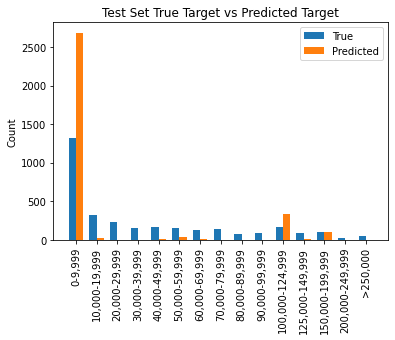

In [ ]:
#plotting Test Dataset True Target vs Predicted Target
salary_buckets = ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
                  '40,000-49,999', '50,000-59,999', '60,000-69,999',
                  '70,000-79,999', '80,000-89,999', '90,000-99,999',
                  '100,000-124,999', '125,000-149,999', '150,000-199,999',
                  '200,000-249,999', '>250,000']
test_data_counts = Counter(y_test['Q24_buckets'])
test_pred_counts = Counter(y_test_pred) 

x = np.arange(len(salary_buckets))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, get_ordered_salary_counts(test_data_counts, salary_buckets), width, label='True')
rects2 = ax.bar(x + width/2, get_ordered_salary_counts(test_pred_counts, salary_buckets), width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Test Dataset True Target vs Predicted Target')
ax.set_xticks(x)
ax.set_xticklabels(salary_buckets)
plt.xticks(rotation=90)
ax.legend()
plt.show()

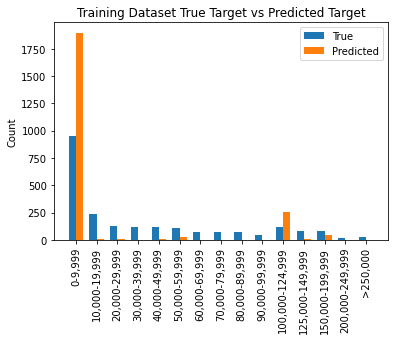

In [ ]:
#plotting Training Dataset True Target vs Predicted Target
#the training set is separted to train and validation at 70:30 to fit the model
X_train1,X_validation = X_train.iloc[0:5257,:],X_train.iloc[5257:7510,:]
y_train1,y_validation = y_train.iloc[0:5257,:],y_train.iloc[5257:7510,:]

y_train_proba = ordinal_logistic_regression(X_train1, y_train1, X_validation, 0.1, 0.01)
y_train_pred = y_train_proba.idxmax(axis='columns')

train_data_counts = Counter(y_validation['Q24_buckets'])
train_pred_counts = Counter(y_train_pred) 

x = np.arange(len(salary_buckets))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, get_ordered_salary_counts(train_data_counts, salary_buckets), width, label='True')
rects2 = ax.bar(x + width/2, get_ordered_salary_counts(train_pred_counts, salary_buckets), width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Training Dataset True Target vs Predicted Target')
ax.set_xticks(x)
ax.set_xticklabels(salary_buckets)
plt.xticks(rotation=90)
ax.legend()
plt.show()